# Project 1

A lot of football experts stated that Europe dominates the World Cup 2018. In order to prove or deny this statement I will perform analysis that compaires centrality measures across europian and non-europian countries.

### Data Gathering

Collect the data from 2018 FIFA World Cup web page (http://www.beinsports.com/en/2018-fifa-world-cup-russia/fixtures-results) using web scrapping technique.

In [376]:
#import libraries
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import re

In [377]:
#read content from http://www.beinsports.com/en/2018-fifa-world-cup-russia/fixtures-results page
html = urlopen("http://www.beinsports.com/en/2018-fifa-world-cup-russia/fixtures-results")
res = BeautifulSoup(html.read(),"html5lib");

#find all football matches
matches = res.findAll("tr", {"itemtype": "https://schema.org/SportsEvent"})

#create list variables to store web content
teams = list()
teams_list = list()
goals = list()
goals_list = list()

#find all teams
for match in matches:
    teams = match.findAll("p", {"itemprop":"performer"})
    for item in teams:
            team = item.get_text().strip()
            teams_list.append(team)

print(teams_list)

#find scores
for match in matches:
    goals = match.findAll("p", {"itemprop":"startDate"})
    for item in goals:
            goal = item.get_text()
            goals_list.append(goal)

print(goals_list)

['RUSSIA', 'SAUDI ARABIA', 'EGYPT', 'URUGUAY', 'MOROCCO', 'IR IRAN', 'PORTUGAL', 'SPAIN', 'FRANCE', 'AUSTRALIA', 'ARGENTINA', 'ICELAND', 'PERU', 'DENMARK', 'CROATIA', 'NIGERIA', 'COSTA RICA', 'SERBIA', 'GERMANY', 'MEXICO', 'BRAZIL', 'SWITZERLAND', 'SWEDEN', 'KOREA REPUBLIC', 'BELGIUM', 'PANAMA', 'TUNISIA', 'ENGLAND', 'COLOMBIA', 'JAPAN', 'POLAND', 'SENEGAL', 'RUSSIA', 'EGYPT', 'PORTUGAL', 'MOROCCO', 'URUGUAY', 'SAUDI ARABIA', 'IR IRAN', 'SPAIN', 'DENMARK', 'AUSTRALIA', 'FRANCE', 'PERU', 'ARGENTINA', 'CROATIA', 'BRAZIL', 'COSTA RICA', 'NIGERIA', 'ICELAND', 'SERBIA', 'SWITZERLAND', 'BELGIUM', 'TUNISIA', 'KOREA REPUBLIC', 'MEXICO', 'GERMANY', 'SWEDEN', 'ENGLAND', 'PANAMA', 'JAPAN', 'SENEGAL', 'POLAND', 'COLOMBIA', 'URUGUAY', 'RUSSIA', 'SAUDI ARABIA', 'EGYPT', 'IR IRAN', 'PORTUGAL', 'SPAIN', 'MOROCCO', 'DENMARK', 'FRANCE', 'AUSTRALIA', 'PERU', 'NIGERIA', 'ARGENTINA', 'ICELAND', 'CROATIA', 'MEXICO', 'SWEDEN', 'KOREA REPUBLIC', 'GERMANY', 'SERBIA', 'BRAZIL', 'SWITZERLAND', 'COSTA RICA', 'JAP

### Data Cleaning

In [378]:
#create matches DataFrame
matches = pd.DataFrame()

#create team 1 variable
matches['team 1'] = teams_list[::2]
#create team 2 variable
matches['team 2'] = teams_list[1::2]

#create scores variable
matches['scores'] = goals_list

matches.tail()

,team 1,team 2,scores
59,SWEDEN,ENGLAND,0-2
60,FRANCE,BELGIUM,1-0
61,CROATIA,ENGLAND,2-1
62,BELGIUM,ENGLAND,2-0
63,FRANCE,CROATIA,18:00


In [379]:
#add missing score for the final match
matches['scores'][len(matches)-1] = '2-4'
matches.tail(10)

,team 1,team 2,scores
54,SWEDEN,SWITZERLAND,1-0
55,COLOMBIA,ENGLAND,1 (3) - 1(4)
56,URUGUAY,FRANCE,0-2
57,BRAZIL,BELGIUM,1-2
58,RUSSIA,CROATIA,2 (3) - 2(4)
59,SWEDEN,ENGLAND,0-2
60,FRANCE,BELGIUM,1-0
61,CROATIA,ENGLAND,2-1
62,BELGIUM,ENGLAND,2-0
63,FRANCE,CROATIA,2-4


Split scores column to two columns - number of goals scored by the team and number of goals scored by the opposite team.

In [380]:
matches['team1_score'] = matches['scores'].str.split('-',expand=True)[0]
matches['team2_score'] = matches['scores'].str.split('-',expand=True)[1]
matches.tail(10)

,team 1,team 2,scores,team1_score,team2_score
54,SWEDEN,SWITZERLAND,1-0,1,0
55,COLOMBIA,ENGLAND,1 (3) - 1(4),1 (3),1(4)
56,URUGUAY,FRANCE,0-2,0,2
57,BRAZIL,BELGIUM,1-2,1,2
58,RUSSIA,CROATIA,2 (3) - 2(4),2 (3),2(4)
59,SWEDEN,ENGLAND,0-2,0,2
60,FRANCE,BELGIUM,1-0,1,0
61,CROATIA,ENGLAND,2-1,2,1
62,BELGIUM,ENGLAND,2-0,2,0
63,FRANCE,CROATIA,2-4,2,4


Convert penalties to goals when goals scored by both teams are equal.

In [381]:
#read integer between parentheses
for i in range(0,len(matches['team1_score'])-1):
    mo = re.search(r'\((.*)\)', matches['team1_score'][i])
    if mo:
        matches['team1_score'][i] = mo.group(1)

#read integer between parentheses
for i in range(0,len(matches['team2_score'])-1):
    mo = re.search(r'\((.*)\)', matches['team2_score'][i])
    if mo:
        matches['team2_score'][i] = mo.group(1)        

matches.tail(10)        

,team 1,team 2,scores,team1_score,team2_score
54,SWEDEN,SWITZERLAND,1-0,1,0
55,COLOMBIA,ENGLAND,1 (3) - 1(4),3,4
56,URUGUAY,FRANCE,0-2,0,2
57,BRAZIL,BELGIUM,1-2,1,2
58,RUSSIA,CROATIA,2 (3) - 2(4),3,4
59,SWEDEN,ENGLAND,0-2,0,2
60,FRANCE,BELGIUM,1-0,1,0
61,CROATIA,ENGLAND,2-1,2,1
62,BELGIUM,ENGLAND,2-0,2,0
63,FRANCE,CROATIA,2-4,2,4


In [382]:
#convert goals variable to numeric type
matches['team1_score'] = matches['team1_score'].astype(float)
matches['team2_score'] = matches['team2_score'].astype(float)

#create two new columns - 'winning team' and 'losing team'
matches['winning_team'] = np.where(matches['team1_score'] > matches['team2_score'], matches['team 1'],matches['team 2'])
matches['losing_team'] = np.where(matches['team1_score'] < matches['team2_score'], matches['team 1'],matches['team 2'])

#remove matches that have equal numer of goals scored by two teams 
matches = matches[matches['winning_team']!=matches['losing_team']]
#reindex
matches.reset_index(inplace=True)
matches[['winning_team','losing_team']].head(10)

,winning_team,losing_team
0,RUSSIA,SAUDI ARABIA
1,URUGUAY,EGYPT
2,IR IRAN,MOROCCO
3,FRANCE,AUSTRALIA
4,DENMARK,PERU
5,CROATIA,NIGERIA
6,SERBIA,COSTA RICA
7,MEXICO,GERMANY
8,SWEDEN,KOREA REPUBLIC
9,BELGIUM,PANAMA


Add the categorical variable 'continent' that can take two values - 'Europe'(for europian countries) and 'non-Europe'(non-europian countries). 

In [383]:
#list of Europian countries
europe_countries = ['Albania','Andorra','Armenia','Austria','Azerbaijan','Belarus','Belgium', 'Bosnia and Herzegovina','Bulgaria','Croatia','Cyprus','Czech Republic','Denmark','Estonia','Finland','France','Georgia','Germany','Greece','Hungary','Iceland','Ireland','Italy','Kazakhstan','Kosovo','Latvia','Liechtenstein','Lithuania','Luxembourg','Macedonia','FYROM','Malta','Moldova','Monaco','Montenegro','Netherlands','Norway','Poland','Portugal','Romania','Russia','San Marino','Serbia','Slovakia','Slovenia','Spain','Sweden','Switzerland','Turkey','Ukraine','United Kingdom','UK','England','Vatican City','Vatican City','Holy See']
#convert all countries titles to uppercase
europe_countries_list = [ x.upper() for x in europe_countries]

#add attribute continent


continent_list = list()

for i in range(0,len(matches)):
    if matches['winning_team'][i] in europe_countries_list: 
        continent ='Europe'
    else: 
        continent = 'non-Europe'
    continent_list.append(continent) 

matches['winning_team_continent'] = continent_list    


continent_list = list()

for i in range(0,len(matches)):
    if matches['losing_team'][i] in europe_countries_list: 
        continent ='Europe'
    else: 
        continent = 'non-Europe'
    continent_list.append(continent)

matches['losing_team_continent'] = continent_list

matches[['winning_team','losing_team' ,'winning_team_continent' ,'losing_team_continent']].head()

,winning_team,losing_team,winning_team_continent,losing_team_continent
0,RUSSIA,SAUDI ARABIA,Europe,non-Europe
1,URUGUAY,EGYPT,non-Europe,non-Europe
2,IR IRAN,MOROCCO,non-Europe,non-Europe
3,FRANCE,AUSTRALIA,Europe,non-Europe
4,DENMARK,PERU,Europe,non-Europe


### Data Vizualization

Draw a directed graph using Python library 'networkx' (For graph vizualization I decided to use networkx instead of neo4j). Vertices represent team countries.  All the edges are directed from winning team to losing team. 

In [384]:
#create empty graph
G = nx.DiGraph()

#add edges
edges = list()
for index, row in matches.iterrows():
    edge = (row['winning_team'], row['losing_team'])
    edges.append(edge)

G.add_edges_from(edges)

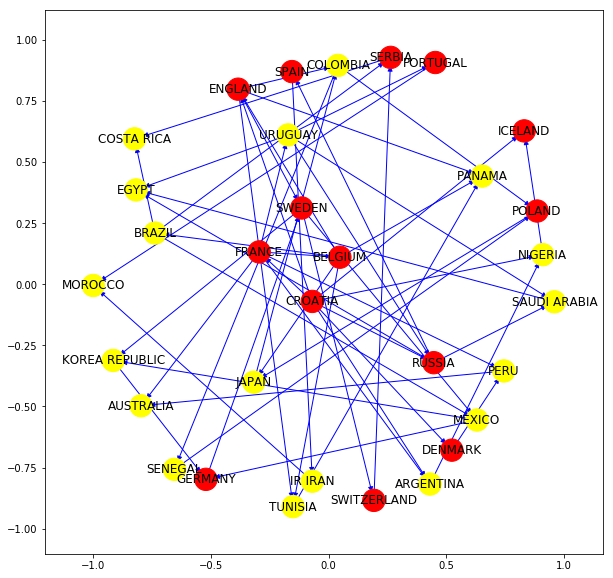

In [385]:
#draw graph
#select layout
pos = nx.spring_layout(G,k=1.5)
#adjust size
plt.figure(figsize = (10,10))

#color europian countries in red and non-europian countries in yellow
color_map = []
for node in G:
    if node in europe_countries_list:
        color_map.append('red')
    else: color_map.append('yellow')      
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = color_map, node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='b', arrows=True)

#increase size of graph
plt.show()


### Centrality Measures

Calculate degree centrality for each node (team). Degree centrality identifies how manuy connections each node has to other nodes within the network. Since the FIFA network is directed degree centrality mesuares by in-degree or out-degree. Let's calculate out-degree that specifies the number of out-going links or the number of successor nodes.

In [386]:
#calculate degree_centrality 
degree_centrality = matches.groupby('winning_team').size().reset_index()
degree_centrality.columns = ['winning_team', 'degree_centrality']

degree_centrality.sort_values('degree_centrality', ascending=False)

,winning_team,degree_centrality
4,CROATIA,7
1,BELGIUM,6
7,FRANCE,5
25,URUGUAY,4
6,ENGLAND,4
17,RUSSIA,3
2,BRAZIL,3
22,SWEDEN,3
3,COLOMBIA,2
12,MEXICO,2


Let's calculate group degree centrality for Europian and non-Europian countries. Group degree centrality as the number of non-group nodes that are connected to group members.

In [387]:
matches[['winning_team','losing_team' ,'winning_team_continent' ,'losing_team_continent']].head()

,winning_team,losing_team,winning_team_continent,losing_team_continent
0,RUSSIA,SAUDI ARABIA,Europe,non-Europe
1,URUGUAY,EGYPT,non-Europe,non-Europe
2,IR IRAN,MOROCCO,non-Europe,non-Europe
3,FRANCE,AUSTRALIA,Europe,non-Europe
4,DENMARK,PERU,Europe,non-Europe


In [388]:
matches.groupby(['winning_team_continent' ,'losing_team_continent']).size().reset_index()

,winning_team_continent,losing_team_continent,0
0,Europe,Europe,13
1,Europe,non-Europe,22
2,non-Europe,Europe,8
3,non-Europe,non-Europe,12


Group degree centrality for europian countries is 22 and group centrality for non-europian countries is 8. 

Calculate EigenCentrality. EigenCentrality measures a node’s influence based on the number of links it has to other nodes within the network.

In [389]:
centrality = nx.eigenvector_centrality_numpy(G)
eigenvector_centrality = pd.DataFrame(list(centrality.items()), index=range(0,len(centrality)),columns=['team','eigenvector_centrality'])
eigenvector_centrality['eigenvector_centrality']=round(eigenvector_centrality['eigenvector_centrality'],2)
eigenvector_centrality.sort_values('eigenvector_centrality', ascending=False)

,team,eigenvector_centrality
15,GERMANY,0.58
17,KOREA REPUBLIC,0.51
16,SWEDEN,0.41
14,MEXICO,0.30
31,SWITZERLAND,0.30
12,SERBIA,0.21
13,COSTA RICA,0.15
5,MOROCCO,0.00
20,ENGLAND,0.00
30,ICELAND,0.00
